In [1]:
import pandas as pd
import numpy as np
import micplot 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
#config cell

FIFA_RANKING = {'België': 1,
 'Frankrijk': 2,
 'Engeland': 4,
 'Portugal': 5,
 'Spanje': 6,
 'Italië': 7,
 'Denemarken': 10,
 'Duitsland': 12,
 'Zwitserland': 13,
 'Kroatië': 14,
 'Nederland': 16,
 'Wales': 17,
 'Zweden': 18,
 'Polen': 21,
 'Oostenrijk': 23,
 'Oekraïne': 24,
 'Servië': 25,
 'Turkije': 29,
 'Slowakije': 36,
 'Hongarije': 37,
 'Rusland': 38,
 'Tsjechië': 40,
 'Noorwegen': 42,
 'Roemenië': 43,
 'Schotland': 44,
 'Ierland': 47,
 'Noord-Ierland': 48,
 'Griekenland': 51,
 'Ijsland': 52,
 'Finland': 54,
 'Bosnië-Hercegovina': 55,
 'Noord-Macedonië': 62,
 'Slovenië': 63,
 'Montenegro': 64,
 'Albanië': 66,
 'Bulgarije': 71,
 'Israel': 85,
 'Belarus': 89,
 'Armenië': 90,
 'Georgië': 91,
 'Luxemburg': 96,
 'Cyprus': 97,
 'Azerbeidjan': 110,
 'Faroer eilanden': 113,
 'Estland': 116,
 'Kosovo': 120,
 'Kazachstan': 124,
 'Litouwen': 134,
 'Letland': 138,
 'Andorra': 158}

PLAYERIDS = {
    'DummyClassifier': 121338,
    'GerW': 69504,
    'Moncef': 113174,
    'semjansen': 69968,
    'Lisanne123': 95376,
    'maryse_ajax': 109196,
    'HelderziendeMark': 96571,
    'crazy_bones_tm': 111985,
    'Kanye2024': 117015,
    'RensLokerse': 111878,
    'SjoerdCor': 91499,
    'BelgieEKWinnaar': 93118,
    'tby': 137331,
    
}

POOL_ID = 6808
URL_UITSLAGEN = 'https://www.ekpooltjes.nl/fixtures/'

## Data collection and preparation

In [3]:
def read(url, **kwargs):
    return pd.read_html(url, **kwargs)[0]


def clean_uitslagen(df):
    df = (df.loc[lambda df: df.nunique('columns').gt(4)]  # Drops header rows which has "groepswedstrijden 5 times" - leaves only match rows
          
          .set_axis(['WedstrijdNr','TeamThuis', 'TeamUit', 'Datum', 'Tijd', 'Score'], 'columns')
          .assign(WedstrijdNr = lambda df: pd.to_numeric(df['WedstrijdNr']))
          .set_index('WedstrijdNr')
         )  
    return df

    
def calculate_round(df):
    r = (df.reset_index() # Melt, keeping wedstrijd nr
         .melt(id_vars=['WedstrijdNr'], value_vars=['TeamThuis', 'TeamUit'])
         .set_index('WedstrijdNr')
         .sort_index()
         .groupby(['value']).transform('cumcount').add(1) 
        )
#     assert r.groupby('WedstrijdNr').nunique().eq(1).all(), 'Differing rounds for one match!'
    return r.groupby('WedstrijdNr').min()

def create_poule_dict(table):
    standing = table.iloc[:4, 0]
    countries = standing.str.strip('*').str.strip().values
    poule = standing.name.split(' ')[1]
    dct = {c: poule for c in countries}
    return dct

def read_poule_indeling():
    url = 'https://www.ek2020-voetbal.nl/poules-ek-2020/'
    tables = pd.read_html(url)
    total = {}
    for table in tables:
        poule = create_poule_dict(table)
        total = {**total, **poule}
    return total





def calculate_features(df):
    poule_indeling = read_poule_indeling()

    df = df.assign(Round = lambda df: calculate_round(df),
                   Poule = lambda df: np.where(df['Round'].le(3), df['TeamThuis'].map(poule_indeling), np.nan)
                  )
    return df
    
df = read(URL_UITSLAGEN).pipe(clean_uitslagen).pipe(calculate_features)

In [4]:
def predict_fifa_based(home_team, away_team):
    try:
        home_fifa_rank = FIFA_RANKING[home_team]
        away_fifa_rank = FIFA_RANKING[away_team]
    except KeyError:
        return None
    
    if home_fifa_rank < away_fifa_rank:
        return '2 - 0'
    return '0 - 2'

def predict_dummy():
    return '2 -  0'

def predict_mode(predictions):
    return predictions.mode('columns')[0]

In [5]:
def add_wedstrijdnr_as_index(predictions, results):
    """
    Add wedstrijdnr from results df
    
    The order of matches does not always match for simultaneous (group) matches because of EKpooltjes' inconsistency
    """
    
    def add_match_occurrence(df):
        """
        We can match matches based on the home team, away team and the occurrence of this match within the tournament, since
        two teams can play the same match twice; once in group stage, once in (semi-)finals
        """
        return df.assign(MatchOccurrence = lambda df: df.groupby(['TeamThuis', 'TeamUit']).cumcount())
    
    
    results_copy = (results.pipe(add_match_occurrence)
                   .filter(['TeamThuis','TeamUit', 'MatchOccurrence'])
                    .reset_index()
                   )
    
    predictions = (predictions.pipe(add_match_occurrence)
                    .merge(results_copy)
                    .drop(columns=['MatchOccurrence'])  # Was solely for merging
                    .set_index('WedstrijdNr')
                    )
    return predictions

In [6]:
def create_predictions_url(name):
    player_id = PLAYERIDS[name]
    # While this is pool specific, this url with anyone's predictions is still available without a password
    url = f'https://www.ekpooltjes.nl/prediction/{player_id}/{POOL_ID}/'  
    return url

def read_predictions(name):
    player_url = create_predictions_url(name)
    return read(player_url, na_values='-')

def clean_predictions(df, name, results=df):
    df = (df.set_axis(['TeamThuis', 'TeamUit', 'Prediction', 'Uitslag', 'Punten'], 'columns')
          .loc[lambda df: df.nunique('columns').gt(1)]  # Drops header rows which has "groepswedstrijden" 5 times - leaves only match rows
          .pipe(add_wedstrijdnr_as_index, results)
          .drop(columns=['Uitslag', 'TeamThuis', 'TeamUit', 'Punten']) # from other df and self calculated
          .rename(columns={'Prediction': f'Prediction_{name}'})
         )  
    return df

def create_predictions_df():
    return pd.concat([read_predictions(name).pipe(clean_predictions, name) for name in PLAYERIDS.keys()], axis='columns').sort_index()

def add_dummy_predictions(df, fixtures):
    df = df.assign(DummyPredictionFIFA = lambda df: [predict_fifa_based(*fixtures.loc[matchid, ['TeamThuis', 'TeamUit']]) for matchid in df.index],
                   DummyPredictionAlways2_0 = lambda df: predict_dummy(),
                   DummyPredictionMode = lambda df: predict_mode(df),
                   )
    return df
    

predictions = create_predictions_df().pipe(add_dummy_predictions, fixtures=df)
predictions

,Prediction_DummyClassifier,Prediction_GerW,Prediction_Moncef,Prediction_semjansen,Prediction_Lisanne123,Prediction_maryse_ajax,Prediction_HelderziendeMark,Prediction_crazy_bones_tm,Prediction_Kanye2024,Prediction_RensLokerse,Prediction_SjoerdCor,Prediction_BelgieEKWinnaar,Prediction_tby,DummyPredictionFIFA,DummyPredictionAlways2_0,DummyPredictionMode
WedstrijdNr,,,,,,,,,,,,,,,,
1,0 - 1,1 - 2,1 - 2,0 - 0,1 - 3,1 - 3,1 - 2,0 - 2,2 - 1,0 - 1,1 - 1,0 - 1,0 - 1,0 - 2,2 - 0,0 - 1
2,1 - 2,1 - 2,0 - 1,0 - 1,0 - 0,1 - 1,0 - 1,0 - 0,1 - 2,1 - 1,0 - 2,1 - 2,0 - 2,0 - 2,2 - 0,1 - 2
3,2 - 1,2 - 0,2 - 1,2 - 0,3 - 2,2 - 0,2 - 0,1 - 1,0 - 1,2 - 0,3 - 0,0 - 0,2 - 0,2 - 0,2 - 0,2 - 0
4,2 - 1,3 - 0,3 - 1,1 - 0,3 - 1,2 - 1,3 - 1,2 - 1,2 - 0,3 - 1,1 - 1,3 - 0,2 - 1,2 - 0,2 - 0,2 - 1
5,2 - 1,2 - 1,2 - 0,1 - 0,2 - 1,2 - 2,2 - 0,2 - 2,1 - 0,2 - 1,2 - 1,1 - 2,1 - 2,2 - 0,2 - 0,2 - 1
6,2 - 0,1 - 0,3 - 1,2 - 0,3 - 0,2 - 0,2 - 0,2 - 1,0 - 0,2 - 0,2 - 0,0 - 0,1 - 0,2 - 0,2 - 0,2 - 0
7,2 - 1,2 - 1,2 - 0,2 - 1,2 - 1,2 - 0,3 - 0,1 - 1,2 - 0,1 - 0,3 - 1,1 - 1,2 - 0,2 - 0,2 - 0,2 - 0
8,0 - 1,1 - 1,1 - 1,0 - 0,2 - 2,1 - 1,1 - 1,1 - 1,1 - 1,1 - 0,1 - 1,1 - 1,2 - 1,0 - 2,2 - 0,1 - 1
9,1 - 2,1 - 0,2 - 1,2 - 0,0 - 0,3 - 0,2 - 1,0 - 1,2 - 1,2 - 0,2 - 0,3 - 1,1 - 0,2 - 0,2 - 0,2 - 0


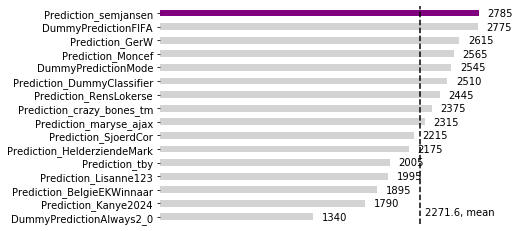

In [7]:
def score_predictions(true_scores, predictions):
    return [score_ekpooltjes_points(true_score, prediction) for true_score, prediction in zip(true_scores, predictions)]

def score_to_goals(score):
    try:
        goals = score.replace(' ', '').split('-')
    except AttributeError:
        return (np.nan, np.nan)
    return int(goals[0]), int(goals[1])

def score_ekpooltjes_points(true_score, predicted_score):
    if isinstance(predicted_score, float) and np.isnan(predicted_score): # must check type first because isnan only works for floats
        return 0
    
    true_goals = score_to_goals(true_score)
    predicted_goals = score_to_goals(predicted_score)
    if true_goals == predicted_goals:
        return 200
    
    true_goals_home, true_goals_away = true_goals
    predicted_goals_home, predicted_goals_away = predicted_goals
    
    predicted_right_winner = ((predicted_goals_home > predicted_goals_away) and (true_goals_home > true_goals_away)
                             or (predicted_goals_home < predicted_goals_away) and (true_goals_home < true_goals_away)
                             )
    predicted_right_draw = (predicted_goals_home == predicted_goals_away) and (true_goals_home == true_goals_away)
    
    predicted_right_n_goals_home = predicted_goals_home == true_goals_home
    predicted_right_n_goals_away = predicted_goals_away == true_goals_away
    
    points = (predicted_right_winner * 75 
             + predicted_right_draw * 100 
             + predicted_right_n_goals_home * 20
             + predicted_right_n_goals_away * 20)
    return points
    
def calculate_scored_points_per_game(predictions, true_score):
    df = predictions.join(true_score).dropna(subset=[true_score.name]).drop(columns=[true_score.name])
    return df.apply(lambda col: score_predictions(true_score, col))

points_per_game = calculate_scored_points_per_game(predictions, df['Score'])
standing = points_per_game.sum().sort_values(ascending=False)
micplot.visualize(standing)
plt.show()

Als referentie zijn 3 DummyPredictions aan de pool toegevoegd:
* DummyPredictionFIFA: Het land met de hoogste FIFA-ranking wint met 2-0
* DummyPredictionMode: De meest gekozen voorspelling van de Spot-onners
* DummyPredictionAlways2_0: Elke wedstrijd wordt 2-0, houdt geen rekening met welke landen spelen

Zo ver nog geen verrassingen: Moncef heeft ruimschoots de leiding en houdt als enige de DummyPrediction van de FIFA-ranking volgen achter zich: #successenvieren

## De stand ontleed
Maar ~~Parijs~~ Londen is nog ver; het gaat niet alleen om de huidige stand, maar ook wat we kunnen verwachten voor de toekomst. Worden er meer of minder punten gescoord?

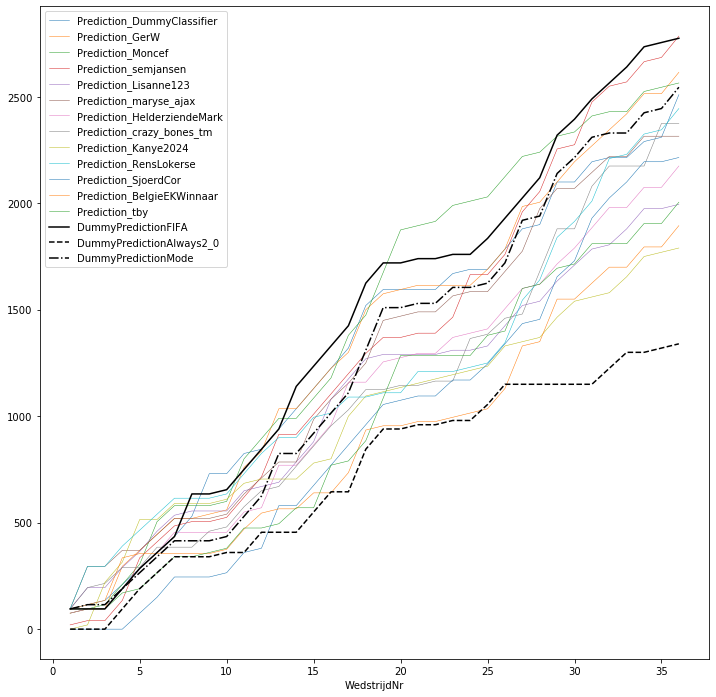

In [8]:
ax = points_per_game.filter(regex='^(?!DummyPrediction)').cumsum().plot(figsize=(12,12), linewidth=0.5)
points_per_game.filter(like='DummyPrediction').cumsum().plot(figsize=(12,12),style=['k-', 'k--', 'k-.'], ax=ax)
plt.show()

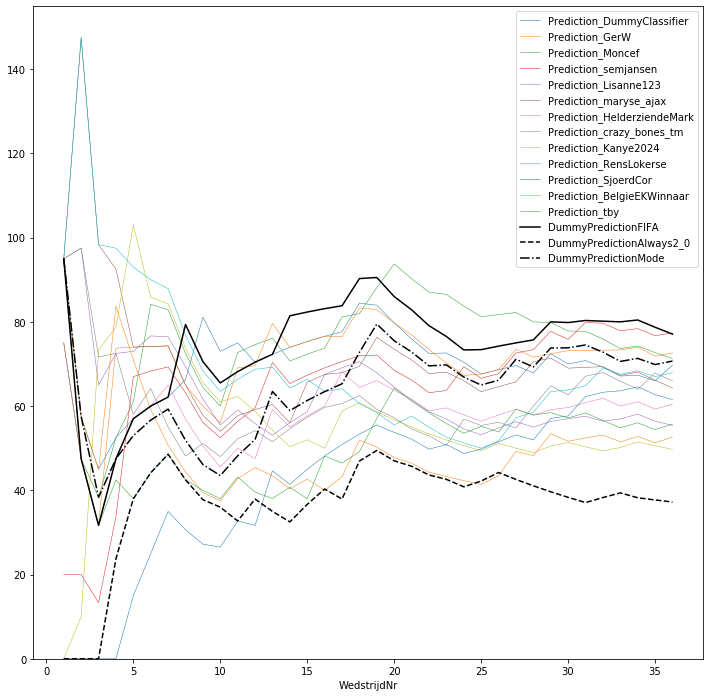

In [9]:
ax = points_per_game.filter(regex='^(?!DummyPrediction)').expanding().mean().plot(figsize=(12,12), linewidth=0.5)
points_per_game.filter(like='DummyPrediction').expanding().mean().plot(figsize=(12,12),style=['k-', 'k--', 'k-.'], ax=ax)
ax.set_ylim(0, None)
plt.show()

### Gemiddeld genomen voorspellen we steeds beter
Goed nieuws: gemiddeld genomen hebben we in de tweede wedstrijdronde 87.5 punten méér gescoord dan in de eerste wedstrijd ronde. Opvallend is dat die groei ook meer is dan de DummyPredictions, dus wij zijn echt een #lerendeorganisatie.


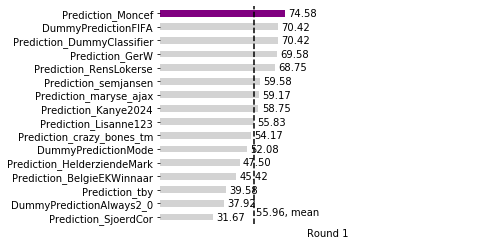

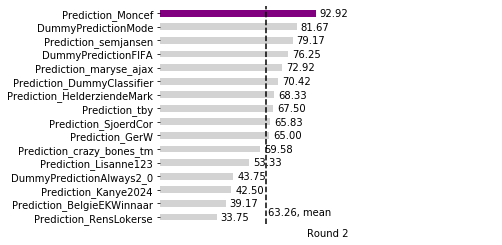

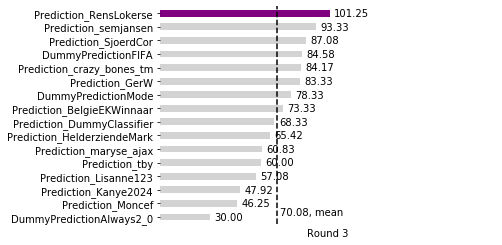

In [10]:
points_per_round = (points_per_game.join(df)
                    .groupby('Round').mean()
                    .transpose()
                    )

for round_ in points_per_round:
    vis = micplot.visualize(points_per_round[round_])
    vis.ax.set_xlim(0, 200)
    vis.ax.set_xlabel(f'Round {round_}')
    plt.show()

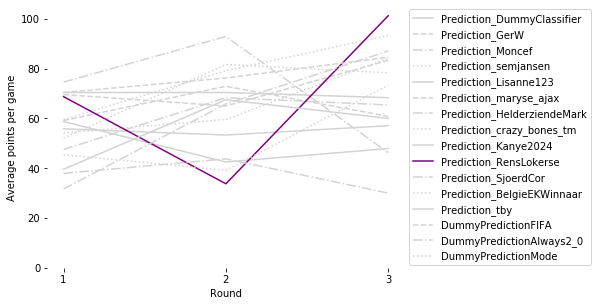

In [51]:
vis = points_per_round.transpose().pipe(micplot.visualize, plottype='line', highlight=[9], figsize=(8,6))
vis.ax.set_ylabel('Average points per game')
vis.ax.set_ylim(0, None)
vis.ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

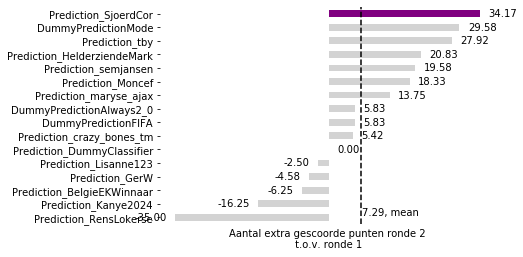

In [12]:
growth = points_per_round[2].sub(points_per_round[1])
vis = micplot.visualize(growth)
vis.ax.set_xlabel('Aantal extra gescoorde punten ronde 2\n t.o.v. ronde 1')
plt.show()

## Overeenkomsten: wie voorspellen altijd hetzelfde?
Er zijn meerdere manieren om te bepalen wie vaak dezelfde voorspelling doen, omdat er meerdere maten van overeenkomst zijn:
* Het percentage dat je exact dezelfde score voorspelt - simpel, maar als de één 2-0 voorspelt en de ander 3-0, lijkt dat meer op elkaar dan 2-0 en 1-4
* De correlatie tussen het aantal gescoorde punten - iets gevoeliger voor wie wanneer goed voorspelt, maar je kunt er op verschillende manieren naast zitten (bv: de uitslag is 1-1, de een voorspelt 2-0 en de ander 2-3 maakt dat voor de correlatie niet uit)
* De "MutualScore": het aantal punten volgens de puntentelling van ekpooltjes.nl als je doet alsof de ene de echte uitslag is en de ander de voorspelde; neemt mooi aantal gescoorde doelpunten en uitslag ook mee

In [13]:
pred_long = predictions.reset_index().melt(id_vars=['WedstrijdNr'], var_name='Voorspeller', value_name='Voorspelling')
preds_compared = pred_long.merge(pred_long, on=['WedstrijdNr']).query('Voorspeller_x > Voorspeller_y')

def add_correlation_measures(df):
    df = df.assign(GelijkeVoorspelling = lambda df: df['Voorspelling_x'] == df['Voorspelling_y'],
                   MutualScore = lambda df: score_predictions(df['Voorspelling_x'], df['Voorspelling_y'])
                   )
    return df
overeenkomst = (preds_compared.pipe(add_correlation_measures)
                .groupby(['Voorspeller_x', 'Voorspeller_y']).mean())


### Mutual score: FIFA-ranking is leidend

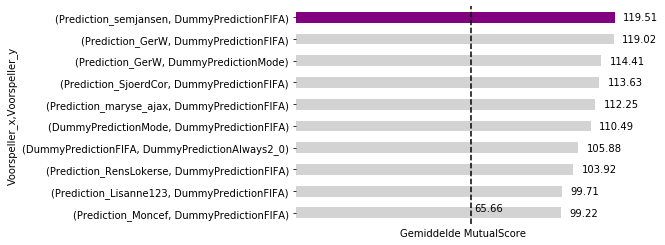

In [14]:
vis = overeenkomst['MutualScore'].nlargest(10).pipe(micplot.visualize, reference_lines=[])
vis.add_reference_line(overeenkomst['MutualScore'].mean())
vis.ax.set_xlabel('Gemiddelde MutualScore')
plt.show()

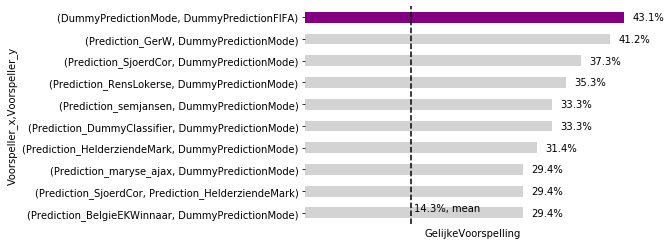

In [15]:
vis = overeenkomst['GelijkeVoorspelling'].nlargest(10).pipe(micplot.visualize, strfmt='.1%', reference_lines=[])
vis.add_reference_line(overeenkomst['GelijkeVoorspelling'].mean(), text='mean')
plt.show()

Het blijkt dat vooral het veel voorspellingen het eens zijn met de dummyvoorspelling op basis van de FIFA-ranglijst. Opvallend is dan wel weer dat de meeste hiervan blijkbaar net niet de goede aanpassingen doen aan deze voorspelling

### Overeenkomsten tussen spot-onners

In [16]:
overeenkomst_no_dummies = overeenkomst.reset_index().loc[lambda df: ~df[['Voorspeller_x', 'Voorspeller_y']].apply(lambda col: col.str.startswith('DummyPrediction')).any('columns')].set_index(['Voorspeller_x', 'Voorspeller_y'])

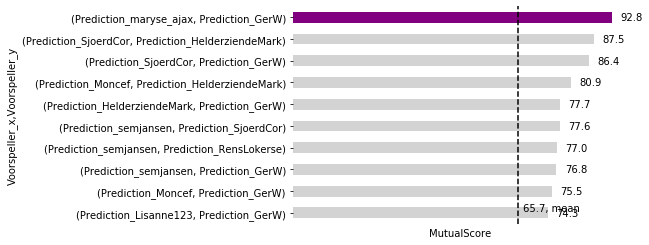

In [17]:
vis = overeenkomst_no_dummies['MutualScore'].nlargest(10).pipe(micplot.visualize, strfmt='.1f', reference_lines=[])
vis.add_reference_line(overeenkomst['MutualScore'].mean(), text='mean')
plt.show()

Als we alleen kijken naar de spotonners, zien we dat Maryse en Ger het meest eens zijn

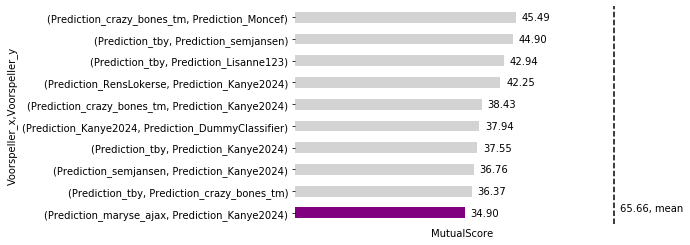

In [18]:
vis = overeenkomst_no_dummies['MutualScore'].nsmallest(10).pipe(micplot.visualize, highlight=0, reference_lines=[])
vis.add_reference_line(overeenkomst['MutualScore'].mean(), text='mean')
plt.show()

Maryse en Kanye2024 zijn het minst eens

### Zelfde voorspelling

Sander en Rens en Sjoerd en Mark voorspellen het vaakst hetzelfde; meer dan een kwart van de keren.

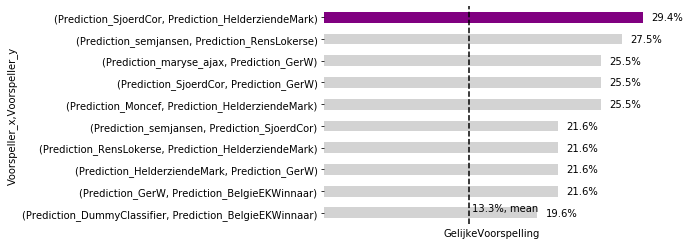

In [19]:
vis = overeenkomst_no_dummies['GelijkeVoorspelling'].nlargest(10).pipe(micplot.visualize, strfmt='.1%', reference_lines=[])
vis.add_reference_line(overeenkomst_no_dummies['GelijkeVoorspelling'].mean(), 'mean')
plt.show()

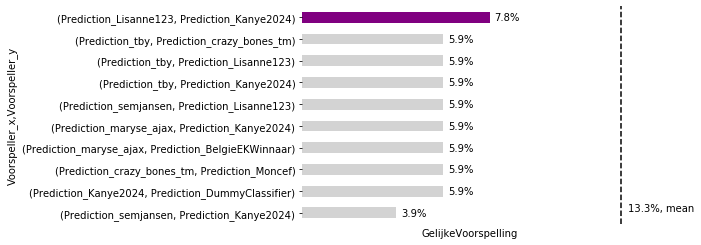

In [20]:
vis = overeenkomst_no_dummies['GelijkeVoorspelling'].nsmallest(10).pipe(micplot.visualize, strfmt='.1%', reference_lines=[])
vis.add_reference_line(overeenkomst_no_dummies['GelijkeVoorspelling'].mean(), 'mean')

plt.show()

Sander en Kanye2024 zijn het echter maar zelden eens.

### Correlaties


In [21]:
corrs = points_per_game.corr().reset_index().melt(id_vars=['index']).query('index > variable').dropna().set_index(['index', 'variable'])['value'].sort_values(ascending=False)
display(corrs.loc[lambda s: s.gt(0.5)].to_frame())

value
index                       variable                             
Prediction_GerW             DummyPredictionMode          0.743132
Prediction_SjoerdCor        DummyPredictionMode          0.690803
Prediction_GerW             Prediction_BelgieEKWinnaar   0.689287
Prediction_SjoerdCor        Prediction_HelderziendeMark  0.669327
Prediction_semjansen        Prediction_SjoerdCor         0.645564
                            DummyPredictionMode          0.636398
Prediction_BelgieEKWinnaar  DummyPredictionMode          0.634546
Prediction_HelderziendeMark DummyPredictionMode          0.630762
Prediction_semjansen        Prediction_HelderziendeMark  0.597528
Prediction_HelderziendeMark Prediction_GerW              0.572138
Prediction_DummyClassifier  DummyPredictionMode          0.566662
Prediction_Moncef           Prediction_HelderziendeMark  0.554707
Prediction_SjoerdCor        Prediction_GerW              0.540544
Prediction_RensLokerse      Prediction_BelgieEKWinnaar   0.528858
Prediction_tby              Prediction_Moncef            0.525103
Prediction_DummyClassifier  Prediction_BelgieEKWinnaar   0.524511
Prediction_Moncef           DummyPredictionMode          0.519423
Prediction_semjansen        Prediction_GerW              0.507028

In [22]:
def order_score(score):
    goals = score_to_goals(score)
    
    return f'{max(goals)} - {min(goals)}'

In [23]:
def recalculate_scores(scores):
    df = (pd.DataFrame([score_to_goals(p) for p in scores], index=predictions.index)
         .assign(
                 TotalGoals = lambda df: df.sum('columns', skipna=False),
                 Margin = lambda df: df[0].sub(df[1]).abs(),
                 Winner = lambda df: df[0] != df[1],
                 Uitslag = lambda df: [order_score(score) for score in scores]
                )
          .rename({0: 'MinGoals', 1: 'MaxGoals'})
         )
    df.columns = pd.MultiIndex.from_product([[scores.name], df.columns])

    return df
    
    

In [24]:
prediction_characteristics = pd.concat([recalculate_scores(predictions[p]) for p in predictions] + [recalculate_scores(df['Score'])], axis='columns').swaplevel(axis=1)

## Waarom score we niet het optimale aantal punten?

### Spot-on voorspelt ongeveer even vaak als de werkelijkheid gelijke spelen

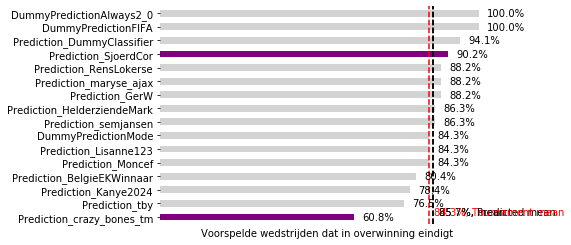

In [25]:
def plot_characteristics(prediction_characteristics, true_col='Score', **kwargs):
    characteristics = prediction_characteristics.copy()
    true_score = characteristics.pop(true_col)
    vis = characteristics.mean(skipna=True).pipe(micplot.micompanyify, **kwargs)
    vis.add_reference_line('mean', text='Predicted mean')
    vis.add_reference_line(true_score.mean(), 'Tournament mean', c='r')
    return vis

vis = plot_characteristics(prediction_characteristics['Winner'],  highlight=[0, -4], strfmt='.1%')
vis.ax.set_xlabel('Voorspelde wedstrijden dat in overwinning eindigt')
plt.show()

Evenwichting en gebalanceerd als we zijn, voorspellen wij dat zo'n 15% van de wedstrijden in een gelijkspel eindigt (tot wel 40% voor crazy_bones_tm). In de werkelijkheid is dat tot nu toe minder dan 11.8%.

### Het gemiddeld aantal doelpunten per wedstrijd zit te laag
Volgens de voorspellingen is dat gemiddeld 2.6, en bijna 20% hoger dan de Spot-on voorspelling. Vooral Sander wordt positief verrast door de aantrekkelijke uitslagen.

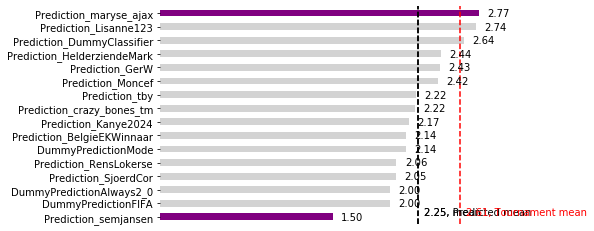

In [26]:
vis = plot_characteristics(prediction_characteristics['TotalGoals'],  highlight=[0, -1])

### Ook de marges zit behoorlijk goed
Qua marges zitten we iets hoger dan de werkelijkheid: wij voorspellen 1.4, net zoals het toernooi. Ook hier zien we echter het hoge remisepercentage van crazy_bones_tm terug.

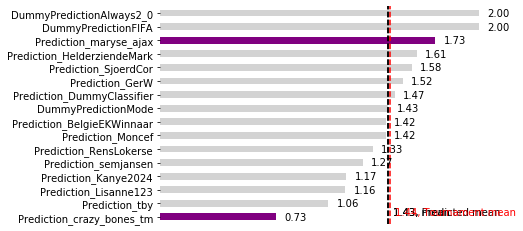

In [27]:
plot_characteristics(prediction_characteristics['Margin'],  highlight=[0, -3])
plt.show()

### Per poule
De eigen poule gaat ons by far het beste af; we scoren meer dan twee keer zoveel punten als in de poules van Engeland en Spanje

In [28]:
poule_scores = points_per_game.join(df).groupby('Poule').mean().drop(columns='Round')

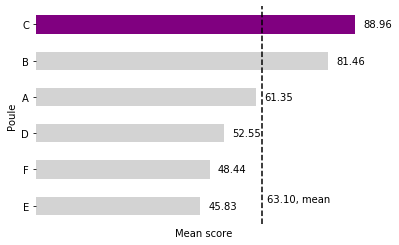

In [29]:
poule_avgs = poule_scores.mean(axis='columns')
vis = micplot.visualize(poule_avgs)
vis.ax.set_xlabel("Mean score")
plt.show()

In [30]:
poule_scores_per_player = poule_scores.div(poule_avgs, axis='index')

In [31]:
poule_scores_per_player.transpose().style.highlight_max().format("{:.0%}")  # Doesn't work on Github

Poule,A,B,C,D,E,F
Prediction_DummyClassifier,109%,99%,105%,90%,135%,141%
Prediction_GerW,98%,136%,125%,84%,104%,129%
Prediction_Moncef,83%,103%,109%,130%,122%,148%
Prediction_semjansen,62%,125%,119%,163%,149%,132%
Prediction_Lisanne123,136%,78%,109%,60%,69%,53%
Prediction_maryse_ajax,160%,65%,119%,60%,122%,84%
Prediction_HelderziendeMark,83%,136%,71%,103%,76%,100%
Prediction_crazy_bones_tm,130%,80%,95%,100%,107%,134%
Prediction_Kanye2024,57%,136%,43%,89%,84%,60%
Prediction_RensLokerse,137%,106%,87%,149%,64%,107%


Zo heeft ieder zijn eigen poule waarin hij/zij het  goed doet.  

## Calculating the probability of winning the pool

Ga ervan uit dat iedereen met dezelfde kwaliteit blijft voorspellen en simuleer dan de scores voor 10.000 verschillende aflopen.

Houd geen rekening met groei (zoals sommige deelnemers lieten zien) of dat mensen stoppen of tactisch spelen, door rekening te houden met wat anderen in

In [32]:
import pymc3 as pm
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [33]:
data = points_per_game.reset_index().melt(id_vars=['WedstrijdNr'], var_name='Voorspeller', value_name='Points')
data

,WedstrijdNr,Voorspeller,Points
0,1,Prediction_DummyClassifier,95
1,2,Prediction_DummyClassifier,20
2,3,Prediction_DummyClassifier,20
3,4,Prediction_DummyClassifier,75
4,5,Prediction_DummyClassifier,75
...,...,...,...
571,32,DummyPredictionMode,20
572,33,DummyPredictionMode,0
573,34,DummyPredictionMode,95
574,35,DummyPredictionMode,20


In [34]:
n_matches_to_play = df['Score'].isnull().sum()
n_players = data['Voorspeller'].nunique()

In [35]:
player_idx = {v: i for i, v in enumerate(data['Voorspeller'].unique())}
idx_player = {i: v for i, v in enumerate(data['Voorspeller'].unique())}

In [36]:
voorspeller_idx = data['Voorspeller'].map(player_idx)
wedstrijd_idx = data['WedstrijdNr']

In [37]:
coords = {'Voorspeller': data['Voorspeller'].unique(),
          'WedstrijdNr': data['WedstrijdNr'].unique()}

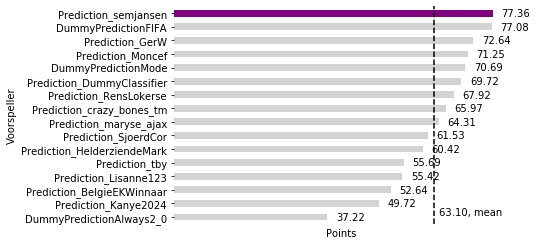

In [38]:
data.groupby('Voorspeller')['Points'].mean().pipe(micplot.visualize)

In [39]:
points_idx_map = {0: 0, 20: 1, 75: 2, 95: 3,100: 4, 200: 5}
idx_points_map = {v: k for k, v in points_idx_map.items()}

In [40]:
voorspeller_idx = data['Voorspeller'].map(player_idx)

In [41]:
with pm.Model(coords=coords) as dirichlet_model:
    
    p = pm.Dirichlet('p', a=np.ones((data['Voorspeller'].nunique(), data['Points'].nunique(), )))
    y = pm.Categorical(name='y', p=p[voorspeller_idx], observed=data['Points'].map(points_idx_map))

    dirichlet_idata = pm.sample(draws=10000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 138 seconds.


In [42]:
%%time
coords_pred = {'Voorspeller': data['Voorspeller'].unique(),
              'WedstrijdNr': np.arange(n_matches_to_play)}
prediction_predictor_idx = np.repeat(np.arange(n_players), n_matches_to_play)

with pm.Model(coords=coords_pred) as model_prediction:

    p = pm.Dirichlet('p', a=np.ones((data['Voorspeller'].nunique(), data['Points'].nunique(), )))
    y = pm.Categorical(name='y', p=p[prediction_predictor_idx], shape=n_matches_to_play * n_players)
    
    preds = pm.fast_sample_posterior_predictive(dirichlet_idata, var_names=['y'])

Wall time: 2min 50s


In [43]:
def restructure_preds(posterior_sample):
    res = (pd.DataFrame(posterior_sample['y'])
             .reset_index()
             .melt(id_vars=['index'], var_name='PredictionID')
             .sort_values(['index', 'PredictionID'])
             .assign(Predictor = lambda df: df['PredictionID'].map({i: idx_player[p] for i, p in enumerate(prediction_predictor_idx)}))
          )
    return res

def calculate_points_per_predictor(results):
    res = (results.assign(value = lambda df: df['value'].map(idx_points_map))
          .groupby(['index', 'Predictor'])['value'].sum()
          .unstack('index')
          )
    return res
    

def calculate_win_pct(predicted_points_to_score, current_standing):
    final_scores_predicted = predicted_points_to_score.add(current_standing, axis='index')
    winner_per_sim = final_scores_predicted.idxmax()
    return winner_per_sim    


In [44]:
def calculate_final_position(final_scores):
    final_positions = (final_scores.rank(ascending=False, method='min')
                         .apply(pd.Series.value_counts, axis=1, normalize=True).fillna(0)
                         .rename_axis('Position', axis='columns')
                         .rename(columns = int)
                         .reindex(current_standing.index)
                         .filter(like='Prediction_', axis='index')
                      )
    return final_positions

In [45]:
current_standing = standing.rename_axis('Predictor')

In [46]:
final_scores = (restructure_preds(preds)
                   .pipe(calculate_points_per_predictor)
                   .add(current_standing, axis='index')
                  )
final_positions = calculate_final_position(final_scores.filter(like='Prediction_', axis='index'))

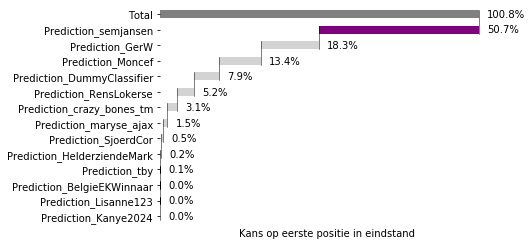

In [53]:
vis = final_positions[1].pipe(micplot.visualize, plottype='waterfall', strfmt='.1%')
vis.ax.set_xlabel('Kans op eerste positie in eindstand')
vis.ax.set_ylabel(None)
plt.show()

Note that it doesn't add up to 100% because of tied winners

In [48]:
(final_positions
 .style.format("{:.1%}")
 .background_gradient()
)

Position,1,2,3,4,5,6,7,8,9,10,11,12,13
Predictor,,,,,,,,,,,,,
Prediction_semjansen,50.7%,23.1%,12.4%,7.1%,3.6%,2.0%,0.8%,0.3%,0.1%,0.0%,0.0%,0.0%,0.0%
Prediction_GerW,18.3%,22.9%,19.4%,15.0%,10.7%,7.0%,3.9%,1.8%,0.8%,0.2%,0.0%,0.0%,0.0%
Prediction_Moncef,13.4%,18.4%,19.0%,15.8%,13.0%,9.3%,5.9%,3.0%,1.5%,0.5%,0.1%,0.0%,0.0%
Prediction_DummyClassifier,7.9%,13.9%,16.9%,17.1%,16.2%,11.9%,8.0%,4.7%,2.4%,0.9%,0.2%,0.0%,0.0%
Prediction_RensLokerse,5.2%,9.7%,12.7%,15.1%,15.9%,14.8%,11.9%,7.6%,4.4%,1.9%,0.8%,0.2%,0.0%
Prediction_crazy_bones_tm,3.1%,6.2%,8.6%,11.9%,13.6%,15.0%,14.0%,11.9%,8.2%,4.6%,2.0%,0.7%,0.2%
Prediction_maryse_ajax,1.5%,3.7%,6.4%,8.4%,11.2%,14.4%,16.1%,14.5%,11.7%,6.8%,3.6%,1.3%,0.4%
Prediction_SjoerdCor,0.5%,1.3%,2.8%,4.7%,7.1%,10.4%,14.4%,17.1%,16.8%,12.9%,7.6%,3.5%,1.0%
Prediction_HelderziendeMark,0.2%,0.7%,1.7%,3.1%,5.3%,8.6%,13.0%,17.9%,19.1%,15.5%,9.2%,4.6%,1.2%


### Better than dummy

In [49]:
def pct_beating_scores(final_scores, ref_scores):
    return final_scores.filter(like='Prediction_', axis='index').gt(final_scores.loc[ref_scores]).mean('columns')

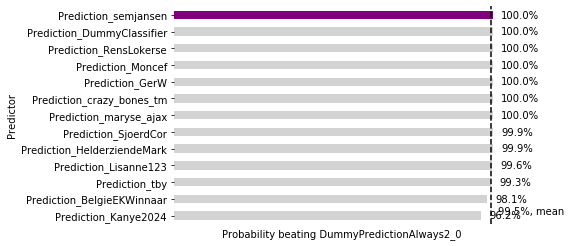

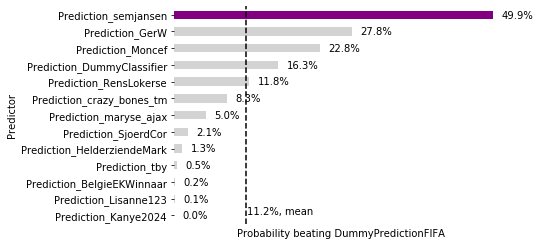

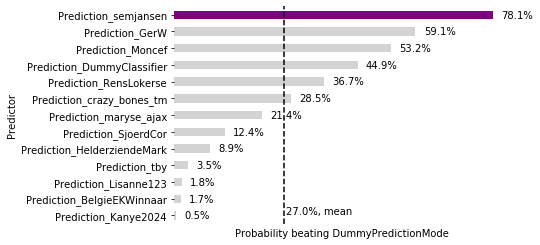

In [50]:
dummies = final_scores.filter(like='DummyPrediction', axis='index').index

for dummy_name in dummies:
    vis = pct_beating_scores(final_scores, dummy_name).pipe(micplot.visualize, strfmt='.1%')
    vis.ax.set_xlabel(f'Probability beating {dummy_name}')